In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#style.use(('ggplot', 'seaborn-muted'))
style.use('seaborn-muted')
rc("image",cmap='gray',aspect='equal',interpolation='nearest')
rc("figure", figsize=(13,8))
#rc('font',family='ubuntu')
rc('axes', labelsize=16)
#from __future__ import division

In [3]:
from numba import jit

In [4]:
def load_stack_with_rescale(name, target_scale=0.2,verbose=False):
    if verbose:
        print(name)
    stack_, meta_ = ccdb.read_pic(name)
    dims_ = ccdb.get_axes(meta_)#[::-1]
    dx, dz = dims_[1][0], dims_[2][0]
    if verbose:
        print(dx,dz)
        print(dx/target_scale, dz/target_scale)
    stackz = ndi.zoom(stack_.astype(float),(dz/target_scale, dx/target_scale,dx/target_scale), order=1)
    return stackz

In [26]:
# change this to your actual path
data_path = '/home/incredible/Neuroscience/selected-for-complexity/data'

In [27]:
cd $data_path

/home/incredible/Neuroscience/selected-for-complexity/data


In [9]:
#sys.path.append('/home/brazhe/proj/semyanov-data/')

In [10]:
from tqdm.auto import tqdm

In [11]:
from importlib import reload

In [12]:
# you need to register at gitlab
# from astromorpho import io as aio
# from astromorpho import enh, morpho

In [13]:
#sys.path.append('/home/brazhe/proj/shearlexity/')

In [14]:
#import shearlexity as shlx

In [15]:
#from imfun.filt import cedf
#from imfun.multiscale import atrous

In [16]:
from scipy import ndimage as ndi

In [17]:
import napari

In [18]:
import ccdb

In [19]:
from pathlib import Path

In [20]:
#pwd

In [28]:
#names = !ls *.pic
names = sorted(Path('./').glob('*.pic'))
#names

In [29]:
names = [name for name in names if not 'hm' in name.name]
len(names)

89

In [30]:

k = randint(len(names))
#k = 18
#k = 48
#k = 63
#k = 81
k = 70

name = names[k]
print(k, name)

zstack = load_stack_with_rescale(name, verbose=True)

70 4wk-ly16-raw.pic
4wk-ly16-raw.pic
0.07708333 0.2
0.38541665 1.0


In [31]:
%gui qt

In [32]:
zstack = zstack[:,10:-45,10:-45]

In [33]:
napari_scale = (0.38, 0.2,t /home/brazhe/.local 0.2)

SyntaxError: invalid syntax (2117532829.py, line 1)

In [34]:
w = napari.view_image(zstack, ndisplay=3, scale=napari_scale)

NameError: name 'napari_scale' is not defined

In [35]:
@jit
def probabilistic_sample(data, weights, Npoints=-1):
    sh = data.shape
    Npoints = len(data) if Npoints < 0 else Npoints
    done = False
    i = 0
    out = np.zeros((Npoints, sh[1]))
    while i < Npoints:
        for k in range(len(data)):
            point = data[k]
            if np.random.rand() < weights[k]:
                out[i] = point
                i+=1
                if i >= Npoints:
                    break
    return out

def percentile_rescale(arr, plow=1, phigh=99.5):
    low, high = np.percentile(arr, (plow, phigh))
    if low == high:
        return np.zeros_like(arr)
    else:
        return np.clip((arr-low)/(high-low), 0, 1)

In [36]:
import itertools as itt

In [37]:
%time X = np.array(list(itt.product(*map(range, zstack.shape)))) # N-dimensional, but slower

CPU times: user 3.6 s, sys: 277 ms, total: 3.88 s
Wall time: 3.88 s


In [38]:
from imfun.filt import l1spline, l2spline

/home/incredible/Neuroscience/venv/lib/python3.8/site-packages/image_funcut-0.6+80.gcf59f2c-py3.8.egg/imfun/external/tifffile.py:7261: UserWarning: No module named 'imfun.external._tifffile'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))


Can't load imreg package, affine and homography registrations won't work


In [39]:
gamma = 1
weights = percentile_rescale(np.ravel(zstack)**gamma)
weights_s = percentile_rescale(np.ravel(ndi.gaussian_filter(zstack,5))**2,plow=99.5,phigh=99.99)
#%time weights_s = percentile_rescale(np.ravel(l1spline(zstack,5))**2,plow=99,phigh=99.9)

In [40]:
center = np.sum(X*weights_s[:,None],axis=0)/np.sum(weights_s)
center

array([ 29.21813018, 181.78860968, 185.07105035])

In [49]:



Xc = X-center

In [50]:
import ucats

In [51]:
multiplicity=3

%time Xp = probabilistic_sample(Xc, weights, multiplicity*len(X))
%time u,s,vh = np.linalg.svd(Xp,full_matrices=False)
u,vh = ucats.decomposition.svd_flip_signs(u,vh, mode='u')
s /= np.sqrt(len(u)-1) # normalize by number of points

CPU times: user 23.4 s, sys: 190 ms, total: 23.6 s
Wall time: 23.6 s
CPU times: user 3.34 s, sys: 4.36 s, total: 7.69 s
Wall time: 1.3 s


In [52]:
vh

array([[ 0.00726326,  0.63771593,  0.77023739],
       [ 0.00113708, -0.77026248,  0.63772598],
       [-0.99997298,  0.00375615,  0.00631975]])

In [53]:
x = array([[(0,0,0), vh[0]]])
x.shape

(1, 2, 3)

In [54]:
x = np.array([[center,vh[k]*2*s[k]] for k in range(3)])
x

array([[[ 2.92412119e+01,  1.92016702e+02,  1.94859695e+02],
        [ 1.19764703e+00,  1.05153636e+02,  1.27005237e+02]],

       [[ 2.92412119e+01,  1.92016702e+02,  1.94859695e+02],
        [ 1.66370217e-01, -1.12699798e+02,  9.33079188e+01]],

       [[ 2.92412119e+01,  1.92016702e+02,  1.94859695e+02],
        [-2.43118375e+01,  9.13213772e-02,  1.53648979e-01]]])

In [55]:
w = napari.view_image(zstack, ndisplay=3, scale=napari_scale)
w.add_image(weights_s.reshape(zstack.shape), colormap='cyan',blending='additive',scale=napari_scale)
w.add_vectors(x, edge_width=3, edge_color_cycle=['red','magenta', 'blue'],scale=napari_scale)

<Vectors layer 'x' at 0x7f4052e688b0>

In [56]:
Y = Xc@vh.T#@np.diag(1/s)

In [57]:
zstack_r = np.ravel(zstack)

In [58]:

Yx1 = Y[:,0][zstack_r > 17]
Yx2 = Y[:,1][zstack_r > 17]
Wx = zstack_r[zstack_r > 17]

In [59]:
xq = arange(-150,250, 5)

In [60]:
#bins1 = np.digitize(Yx1, xq,)

In [61]:
#yq = [np.mean(Wx[bins1==b]) for b in np.unique(bins1)]

In [62]:
#yq2 = [np.mean(Wx[(Yx >= b)*(Yx < b+5)]) for b in xq]

In [63]:
#xq2 = [np.mean(Yx[bins1==b]) for b in np.unique(bins1)]

In [64]:
#len(unique(bins1)), len(xq2)

Text(0.5, 1.0, 'Brightness distribution along first principal axis')

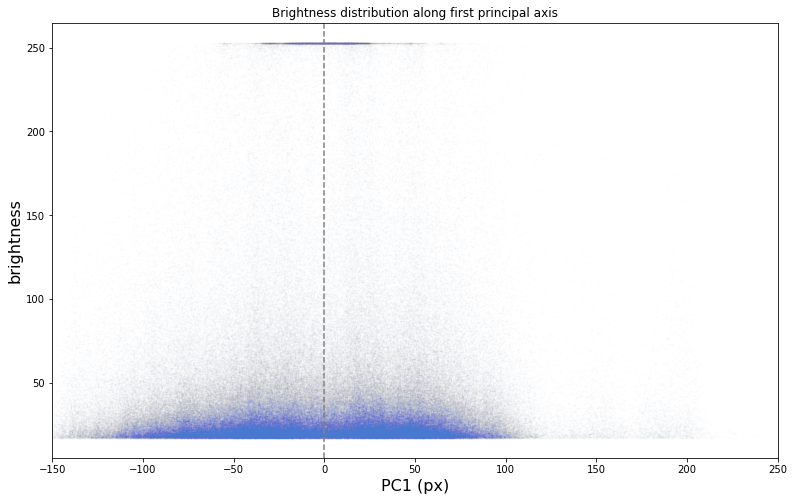

In [65]:
figure()
#plot(Y[:,0],np.ravel(zstack),'.', alpha=0.01)
#hexbin(Y[:,0][zstack_r>17],zstack_r[zstack_r>17],mincnt=5,cmap='plasma',bins='log')
plot(Yx1,Wx,'.',alpha=0.01,markersize=1.5)
xlim(-150,250)
ylabel('brightness')
xlabel('PC1 (px)')
axvline(0, color='gray',ls='--')

#plot(xq+2.5, yq2, lw=2)
#plot(xq2, yq, lw=2)

title('Brightness distribution along first principal axis')

#gcf()

Text(0.5, 1.0, 'Brightness distribution along second principal axis')

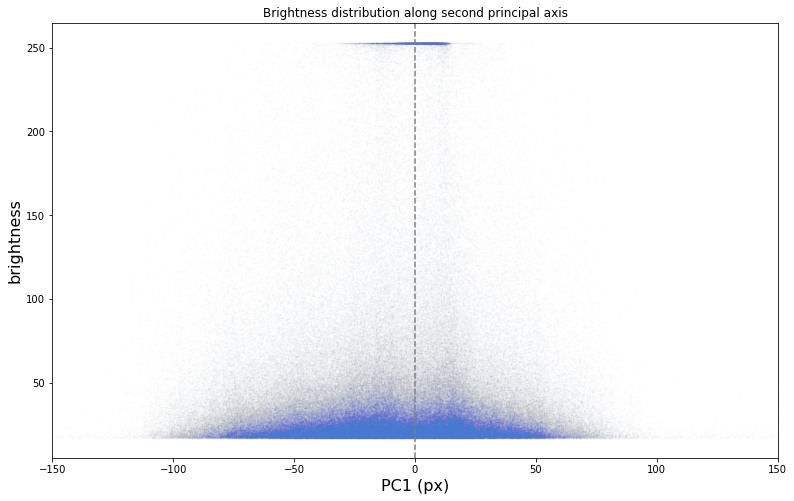

In [66]:
figure()
#plot(Y[:,0],np.ravel(zstack),'.', alpha=0.01)
#hexbin(Y[:,0][zstack_r>17],zstack_r[zstack_r>17],mincnt=5,cmap='plasma',bins='log')
plot(Y[:,1][zstack_r>17],zstack_r[zstack_r>17],'.',alpha=0.01,markersize=1.5)
xlim(-150,150)
ylabel('brightness')
xlabel('PC1 (px)')
axvline(0, color='gray',ls='--')
title('Brightness distribution along second principal axis')

In [67]:
s

array([82.44551519, 73.15674935, 12.15624727])

In [68]:
s[0]/s[1]

1.1269707295864206

In [69]:
np.min(Yx2), np.max(Yx2)

(-272.1642252287356, 273.61083471162357)

In [71]:
#(np.max(Yx)-np.min(Yx))/(np.max(Yx2) - np.min(Yx2))

In [ ]:
#100 * np.sum(Wx[Yx > 0])/np.sum(Wx)

In [ ]:
#100 * np.sum(Wx[Yx < 0])/np.sum(Wx)

In [72]:
anisotropy = s[0]/np.sum(s[:2])
anisotropy

0.5298477848849169

In [73]:
close('all')

In [ ]:
#w.add_vectors?